In [1]:
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from os import path, listdir
import numpy as np
from sklearn.linear_model import LinearRegression

### Load activities

In [2]:
DIRECTORY = 'activities/'
FIGURES = 'figures/'
COLOR = sns.color_palette("YlOrBr_r") #viridis_r
df = pd.DataFrame()
for file in listdir(DIRECTORY):
    new_df = pd.read_json(path.join(DIRECTORY, file))
    df = df.append(new_df)

df = df.reset_index()


### Data cleaning

In [3]:
df['distance'] = df['distance'] / 1000 # meters to km
df['moving_time'] = df['moving_time'].apply(pd.to_timedelta, unit='s')
df['elapsed_time'] = df['elapsed_time'].apply(pd.to_timedelta, unit='s')
df['start_date'] = pd.to_datetime(df['start_date'])
df['average_speed'] = df['average_speed'] * 3.6 # m/s to km/h
df['max_speed'] = df['max_speed'] * 3.6 # m/s to km/h
df['avg_pace'] = 60 / df['average_speed']
#df['pace'].fillna(0)
df['avg_pace'].replace([np.inf, -np.inf], 0, inplace=True)
df['avg_pace'] = df['avg_pace'] #.apply(pd.to_timedelta, unit='m')


In [4]:
df['avg_pace']

0      14.330754
1       0.000000
2       6.332320
3       6.289308
4       0.000000
         ...    
372     5.809225
373     5.509642
374     7.755545
375     6.385696
376     5.226299
Name: avg_pace, Length: 377, dtype: float64

### Sport counts by year

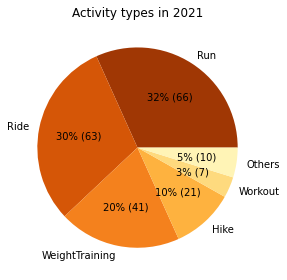

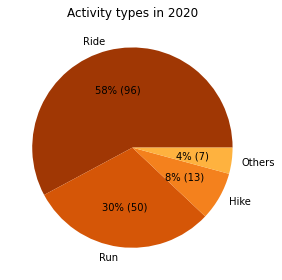

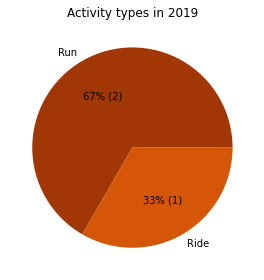

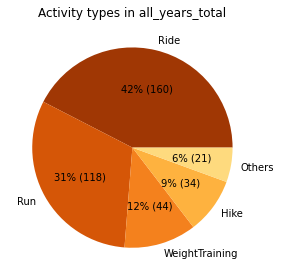

In [5]:
# Create pie chart labels
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.0f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Create years and dataframes for pie charts
years = df['start_date'].dt.year.unique()
dfs = []
for year in years:
    dfs.append(df[df['start_date'].dt.year == year])
dfs.append(df)
years = np.append(years, 'all_years_total')

# Chart for each dataframe
for year, df_iter in zip(years, dfs):
    type_count = df_iter['type'].value_counts()
    small_cols = type_count < type_count.sum() * 0.03
    others = type_count[small_cols].sum()
    if others != 0:
        type_count = type_count[~small_cols]
        type_count['Others'] = others
    fig = plt.figure()
    ax = fig.gca()
    ax = plt.pie(type_count, labels = type_count.index, 
                 autopct=make_autopct(type_count), 
                 colors=COLOR)
    plt.title(f"Activity types in {year}")
    plt.tight_layout()
    plt.savefig(path.join(FIGURES, f"sport_types_{year}"), dpi=800)



### Total info - maxes

In [6]:
max_dist = df['distance'].max()
longest_time = df['moving_time'].max()
heighest_point = df['elev_high'].max()
print(f'Heighest point[M]: {heighest_point}')
print(f'Longest activity[H]: {longest_time}')
print(f'Longest distance[KM]: {max_dist}')

print('Run statistics:')
print(df[df['type'] == 'Run']['distance'].describe())

summed = df['total_elevation_gain'].sum()
print(f'Total elevation gained[M]: {summed}')

Heighest point[M]: 2293.6
Longest activity[H]: 0 days 11:28:02
Longest distance[KM]: 100.536
Run statistics:
count    118.000000
mean       8.926020
std        4.061270
min        2.135400
25%        6.066125
50%        8.117500
75%       10.702800
max       21.315600
Name: distance, dtype: float64
Total elevation gained[M]: 131926.5


### Records by sport

In [7]:
stats_dict = {}
types = ['Run', 'Ride', 'Hike']
for sport in types:
    sport_df = df[df['type'] == sport]
    STATS = ['moving_time', 'elapsed_time', 'distance', 
            'total_elevation_gain', 'average_speed',
            'average_heartrate', 'kudos_count']
    sport_stats = {}
    for stat in STATS:
        sport_stats[f"{stat}_max"] = sport_df[f"{stat}"].max()
        sport_stats[f"{stat}_avg"] = sport_df[f"{stat}"].mean()
    if sport == 'Run':
        sport_stats["pace_min"] = sport_df["avg_pace"].min()
        sport_stats["pace_avg"] = sport_df["avg_pace"].mean()
    stats_dict[sport] = sport_stats

stats_dict

{'Run': {'moving_time_max': Timedelta('0 days 02:17:47'),
  'moving_time_avg': Timedelta('0 days 00:53:39.245762711'),
  'elapsed_time_max': Timedelta('0 days 02:28:31'),
  'elapsed_time_avg': Timedelta('0 days 00:55:46.144067796'),
  'distance_max': 21.3156,
  'distance_avg': 8.926020338983054,
  'total_elevation_gain_max': 853.1,
  'total_elevation_gain_avg': 133.59999999999997,
  'average_speed_max': 12.4308,
  'average_speed_avg': 10.255576271186444,
  'average_heartrate_max': 180.4,
  'average_heartrate_avg': 159.5452991452991,
  'kudos_count_max': 11,
  'kudos_count_avg': 4.406779661016949,
  'pace_min': 4.826720725938797,
  'pace_avg': 5.910468926565065},
 'Ride': {'moving_time_max': Timedelta('0 days 06:07:44'),
  'moving_time_avg': Timedelta('0 days 01:48:40.437500'),
  'elapsed_time_max': Timedelta('0 days 07:12:32'),
  'elapsed_time_avg': Timedelta('0 days 02:05:05.693750'),
  'distance_max': 100.536,
  'distance_avg': 23.814288749999996,
  'total_elevation_gain_max': 2667.0

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

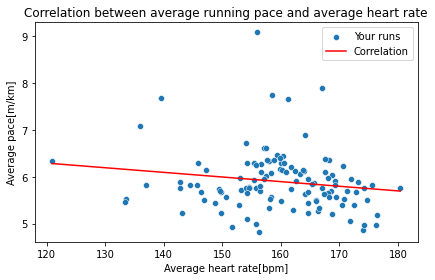

In [35]:
df_tmp = df[df['type'] == 'Run']

# DROP NA, INF, 0.0
df_tmp = df_tmp[~df_tmp['avg_pace'].isin([np.nan, np.inf, 0.0])]
df_tmp = df_tmp[~df_tmp['average_heartrate'].isin([np.nan, np.inf, 0.0])]

avg_hr = df_tmp['average_heartrate'].to_numpy().reshape(-1, 1)
avg_pace = df_tmp['avg_pace'].to_numpy().reshape(-1, 1)
lr = LinearRegression().fit(avg_hr, avg_pace)
predict = lr.predict(avg_hr)
sns.scatterplot(data=df_tmp, x='average_heartrate', y='avg_pace')
sns.lineplot(x=avg_hr.reshape(1, -1)[0], y=predict.reshape(1, -1)[0], color='r')
plt.legend(['Your runs', 'Correlation'])
plt.title('Correlation between average running pace and average heart rate')
plt.xlabel('Average heart rate[bpm]')
plt.ylabel('Average pace[m/km]')
plt.tight_layout()
plt.savefig(path.join(FIGURES,"hr_pace_correlation"), dpi=800)